In [ ]:
import zipfile

# Unzip the file
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_data")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


# Define data paths
train_data = '/content/brain_tumor_data/Training'
test_data = '/content/brain_tumor_data/Testing'

In [ ]:
# Set parameters
batch_size = 32
image_size = (244, 244)

In [ ]:
def dataset_info(path):
    print(f"\n[INFO] Dataset: {path}")
    total_images = 0
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        count = len(os.listdir(folder_path))
        print(f" - {folder}: {count} images")
        total_images += count
    print(f"Total images: {total_images}")

dataset_info(train_data)
dataset_info(test_data)


[INFO] Dataset: /content/brain_tumor_data/Training
 - meningioma: 1339 images
 - pituitary: 1457 images
 - notumor: 1595 images
 - glioma: 1321 images
Total images: 5712

[INFO] Dataset: /content/brain_tumor_data/Testing
 - meningioma: 306 images
 - pituitary: 300 images
 - notumor: 405 images
 - glioma: 300 images
Total images: 1311


In [ ]:
# 2. Data generators with validation split
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_ds = train_gen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_ds = train_gen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1./255)
test_ds = test_gen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # First convolutional block (Grayscale image input)
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(244,244, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Fourth convolutional block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Flattening layer
    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer (4 classes)
    tf.keras.layers.Dense(4, activation='softmax', name='tumor_prob')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 244, 244, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 244, 244, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tumor_prob (Dense)              │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,196,932 (57.97 MB)

 Trainable params: 15,195,908 (57.97 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.5140 - loss: 3.9821 - val_accuracy: 0.2796 - val_loss: 2.4166
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.5701 - loss: 1.3873 - val_accuracy: 0.2787 - val_loss: 3.6017
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.6075 - loss: 0.9558 - val_accuracy: 0.4540 - val_loss: 2.0819
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6396 - loss: 0.8726 - val_accuracy: 0.4452 - val_loss: 1.4525
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6668 - loss: 0.7694 - val_accuracy: 0.7292 - val_loss: 0.7264
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7006 - loss: 0.7216 - val_accuracy: 0.6924 - val_loss: 0.8310
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.7046 - loss: 0.7099 - val_accuracy: 0.6188 - val_loss: 1.0080
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.7246 - loss: 0.6527 - val

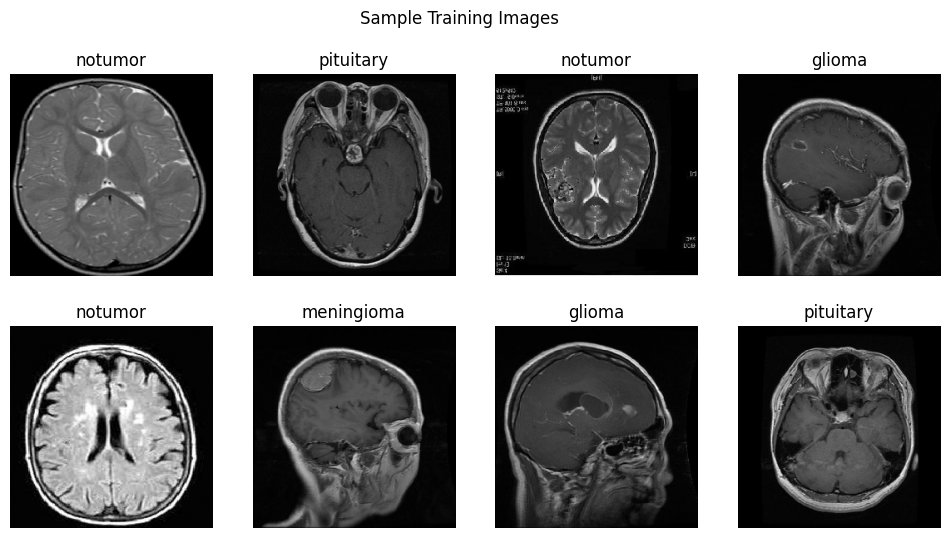

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = list(train_ds.class_indices.keys())

# Fetch a batch of images
x, y = next(train_ds)

# Display 8 sample images from the training data
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x[i].squeeze(), cmap='gray')  # Display grayscale image
    plt.title(class_names[np.argmax(y[i])])
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.show()

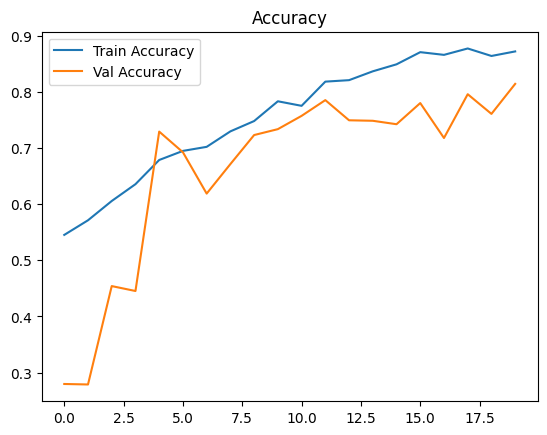

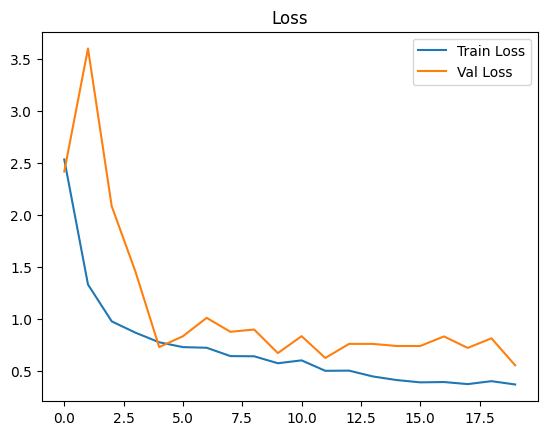

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.tight_layout()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.tight_layout()

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8186 - loss: 0.5645
Validation Accuracy: 81.42


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


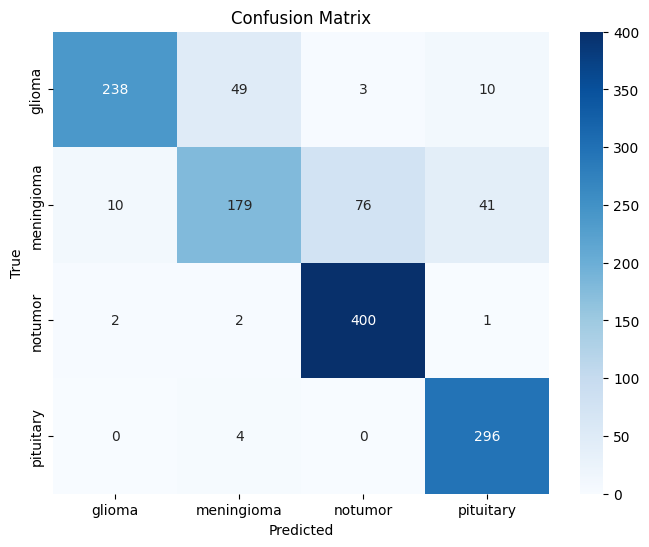

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}")
class_names=['glioma','meningioma','notumor','pituitary']
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, multilabel_confusion_matrix, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_ds.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

accuracy = np.mean(y_pred_classes == y_true)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrices = multilabel_confusion_matrix(y_true, y_pred_classes)
TP = np.zeros(len(class_names))
FP = np.zeros(len(class_names))
FN = np.zeros(len(class_names))
TN = np.zeros(len(class_names))

for i, cm in enumerate(conf_matrices):
  tn, fp, fn, tp = cm.ravel()
  TP[i] = tp
  FP[i] = fp
  FN[i] = fn
  TN[i] = tn

sensitivity = TP / (TP + FN + 1e-10)
specificity = TN / (TN + FP + 1e-10)
miss_rate = 1 - (TP + TN) / (TP + TN + FP + FN + 1e-10)
ppv = TP / (TP + FP + 1e-10)
npv = TN / (TN + FN + 1e-10)
fpr = FP / (FP + TN + 1e-10)
fnr = FN / (FN + TP + 1e-10)
lr_positive = sensitivity / (1 - specificity + 1e-10)
lr_negative = (1 - sensitivity) / (specificity + 1e-10)
f2 = fbeta_score(y_true, y_pred_classes, average='macro', beta=2)
fbeta = fbeta_score(y_true, y_pred_classes, average='macro', beta=0.5)
fmi = np.sqrt(ppv * sensitivity)
fmi_avg = np.mean(fmi)

for i, label in enumerate(class_names):
  print(f"\nClass: {label}")
  print(f" Sensitivity: {sensitivity[i]:.4f}")
  print(f" Specificity: {specificity[i]:.4f}")
  print(f" Miss Rate: {miss_rate[i]:.4f}")
  print(f" PPV: {ppv[i]:.4f}")
  print(f" NPV: {npv[i]:.4f}")
  print(f" FPR: {fpr[i]:.4f}")
  print(f" FNR: {fnr[i]:.4f}")
  print(f" LR+: {lr_positive[i]:.4f}")
  print(f" LR-: {lr_negative[i]:.4f}")
  print(f" Fowlkes-Mallows Index: {fmi[i]:.4f}")

print(f"\nF2 Score: {f2:.4f}")
print(f"Fβ Score (β=0.5): {fbeta:.4f}")
print(f"Average Fowlkes-Mallows Index: {fmi_avg:.4f}")


Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.79      0.87       300
  meningioma       0.76      0.58      0.66       306
     notumor       0.84      0.99      0.90       405
   pituitary       0.85      0.99      0.91       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.84      1311


Accuracy: 0.8490
Precision: 0.8507
Recall (Sensitivity): 0.8382
F1 Score: 0.8367

Class: glioma
 Sensitivity: 0.7933
 Specificity: 0.9881
 Miss Rate: 0.0564
 PPV: 0.9520
 NPV: 0.9416
 FPR: 0.0119
 FNR: 0.2067
 LR+: 66.8383
 LR-: 0.2091
 Fowlkes-Mallows Index: 0.8691

Class: meningioma
 Sensitivity: 0.5850
 Specificity: 0.9453
 Miss Rate: 0.1388
 PPV: 0.7650
 NPV: 0.8821
 FPR: 0.0547
 FNR: 0.4150
 LR+: 10.6889
 LR-: 0.4391
 Fowlkes-Mallows Index: 0.6689

Class: notumor
 Sensitivity: 0.9877
 Specificity: 0.9128
 Miss Rate: 0.0641
 PPV: 

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7761 - loss: 0.5770
✅ Test Accuracy: 84.90%


In [ ]:
model.save('/content/drive/MyDrive/Brain Tumor Classification/All 4 models/customised_saved.h5')